# DS-GA 1019

# Lab 4 - Performance Tunning
## Feb. 16, 2021

In [2]:
import cProfile
import re
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
%load_ext line_profiler

### 1.Taylor series expansion

$$e^x = \sum^\infty_{n=0} 1 + x + \frac{x^2}{2!} + \frac{x^3}{3!} + ...  $$


$$\sin(x) = x - \frac{x^3}{3!} + \frac{x^5}{5!} + ... $$

In [4]:
def factorial(n):
    """A simple recursive function that calculates n!
    """
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)

def taylor_exp(n):
    """Calculates the coefficients of a general taylor expansion of n elements
    """
    res = []
    for i in range(n):
        res.append(1 / factorial(i))
    return res


In [5]:
%lprun -f taylor_exp taylor_exp(1000)

# Notice from the output below that the line that calculates the factorial
# takes the most amount of time.

Timer unit: 1e-06 s

Total time: 0.255491 s
File: /tmp/ipykernel_2650/267269308.py
Function: taylor_exp at line 9

Line #      Hits         Time  Per Hit   % Time  Line Contents
     9                                           def taylor_exp(n):
    10                                               """Calculates the coefficients of a general taylor expansion of n elements
    11                                               """
    12         1          2.0      2.0      0.0      res = []
    13      1001        580.0      0.6      0.2      for i in range(n):
    14      1000     254909.0    254.9     99.8          res.append(1 / factorial(i))
    15         1          0.0      0.0      0.0      return res

In [6]:
def factorial_upto(n):
    """Converting the factorial recursive function to an iterative 
    function that stores the factorial of each number upto n.
    """
    res = [1]
    
    for i in range(1, n + 1):
        res.append(res[-1] * i)
    return res

def better_taylor_exp(n):
    """Optimized function that calculates the coefficients of a taylor 
    expansion using factorial_upto and the built-in map function instead of a 
    for loop.
    """
    factorials = factorial_upto(n)
    
    res = list(map(lambda x: 1/x, factorials))
    return res

In [7]:
%lprun -f better_taylor_exp better_taylor_exp(1000)

Timer unit: 1e-06 s

Total time: 0.000956 s
File: /tmp/ipykernel_2650/2623400775.py
Function: better_taylor_exp at line 13

Line #      Hits         Time  Per Hit   % Time  Line Contents
    13                                           def better_taylor_exp(n):
    14                                               """Optimized function that calculates the coefficients of a taylor 
    15                                               expansion using factorial_upto and the built-in map function instead of a 
    16                                               for loop.
    17                                               """
    18         1        691.0    691.0     72.3      factorials = factorial_upto(n)
    19                                               
    20         1        265.0    265.0     27.7      res = list(map(lambda x: 1/x, factorials))
    21         1          0.0      0.0      0.0      return res

### 2. Heat Equation
Lets further analyze the problem of solving the _heat equation_:
$$
\frac{\partial^2 f}{\partial x^2}+\frac{\partial^2 f}{\partial y^2}=0
$$
using central difference in a square $[0,1]\times[0,1]$ regular grid:
$$
\frac{\partial^2 f}{\partial x^2}\approx\frac{f_{i+1,j}-f_{i,j}+f_{i-1,j} - f_{i,j}}{\Delta x^2} = \frac{f_{i+1,j}+f_{i-1,j} - 2f_{i,j}}{\Delta x^2}
$$

$$
\frac{\partial^2 f}{\partial y^2}\approx \frac{f_{i,j+1}-f_{i,j}+f_{i,j-1} - f_{i,j}}{\Delta y^2} = \frac{f_{i,j+1}+f_{i,j-1} - 2f_{i,j}}{\Delta y^2}
$$

We will assume $\Delta x = \Delta y$, so it follows:
$$
f_{i,j} = \frac{f_{i+1,j}+f_{i-1,j} + f_{i,j+1} + f_{i,j-1}}{4} \,.
$$

We set up initial value at boundary.

Two versions of the code presented in class:

In [10]:
def build_grid(n):
    """defines the grid
    """
    G = np.zeros((n,n))
    return(G)

def set_boundary_grid(G):
    """set the boundary values
    """
    n = G.shape[0]
    G[:,0] = np.ones((1,n))
    G[0,:] = np.ones((1,n)) 
    G[-1,:] = np.ones((1,n))
    G[:,-1] = np.ones((1,n))
    
def calc_error(G1,G2):
    """Calculate the MSE between G1 and G2
    """
    error = np.square(np.subtract(G1, G2)).mean()
    return(error)

def copy_array(G1,G2):
    """Copy the values of G1 into G2
    """
    G2[:] = G1[:]

In [11]:
def solve_heat_equation(n,update):
    """Function sets the grid G and solves the heat equation by updating the 
    grid until it converges within an error of 1e-7
    Note - we are passing the function that updates G as a parameter
    """
    G = build_grid(n)
    set_boundary_grid(G)
    G_prev = build_grid(n)
    copy_array(G, G_prev)
    error = float('inf')
    while error > 1e-7:
        update(G)
        error = calc_error(G,G_prev)
        copy_array(G, G_prev)    
    return(G)

In [13]:
def itera(G):
    """Function to update G using an iterative method. A nested loop is used
    to traverse G and update each value.
    """
    n = G.shape[0]
    for i in range(1,n-1):
        for j in range(1,n-1):
            G[i,j]=(G[i+1,j]+G[i-1,j]+G[i,j+1]+G[i,j-1])/4

#### Convolution 

A mathematical operation between two functions f,h that produces a third function.

$$y = x * h$$
$$y = \sum^{a}_{s = -a} \sum^{b}_{t = -b} h(s,t) f(x-s, y-t)  $$

In [14]:
def itera_conv(G):
    """Function to update G using convolution. scipy.signal.convolve is used to
    update G with the filter f
    """
    n = G.shape[0]
    f = np.array(
        [
            [0,1/4,0], 
            [1/4,0,1/4], 
            [0,1/4,0]
        ]
    )
    G[1:n-1,1:n-1] = scipy.signal.convolve(G, f, 'valid')
    

In [15]:
sol1 = solve_heat_equation(70,itera)
sol2 = solve_heat_equation(70,itera_conv)

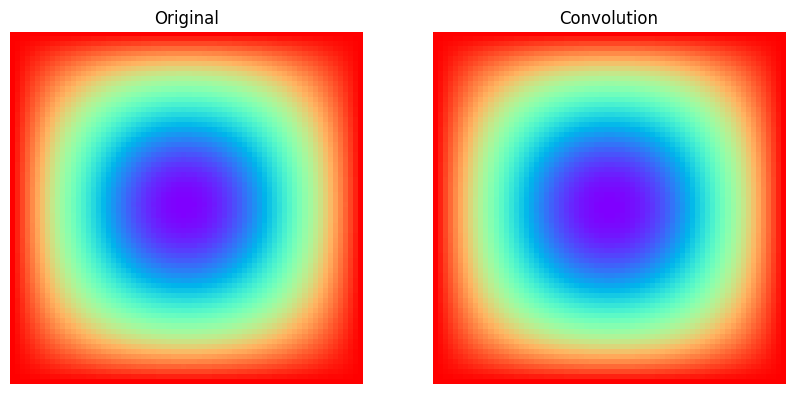

In [16]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.title('Original')
img=plt.imshow(sol1)
img.set_cmap('rainbow')
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Convolution')
img=plt.imshow(sol2)
img.set_cmap('rainbow')
plt.axis('off')
plt.show()

In [17]:
def itera_slicing(G):
    """Function to update G by slicing. G is sliced and 4 separate np.arrays
    are created. Each of these np.arrays contains the values of the 
    left neighbors, right neighbors, top neighbors and bottom neighbors for
    every element in G.
    """
    n = G.shape[0]

    Gl = G[1:-1,:-2]  #Left neighbors
    Gr = G[1:-1,2:]   #Right neighbors
    Gt = G[2:,1:-1]   #top neighbors
    Gb = G[:-2,1:-1]  #bottomneighbors
    
    G[1:n-1,1:n-1] = (Gl + Gr + Gt + Gb)/4
    
sol3 = solve_heat_equation(70,itera_slicing)

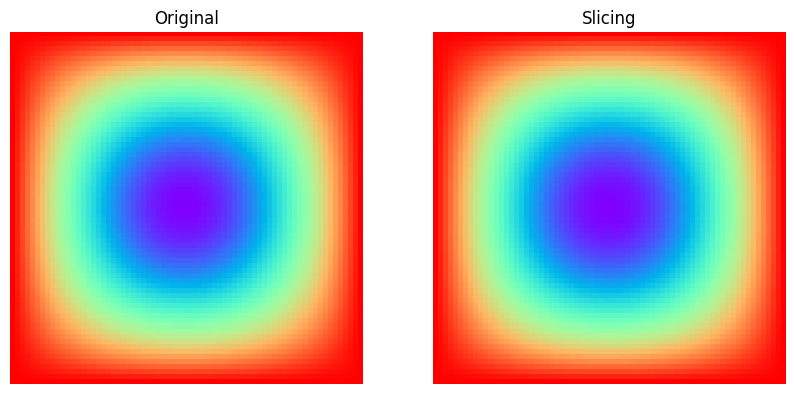

In [18]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.title('Original')
img=plt.imshow(sol1)
img.set_cmap('rainbow')
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Slicing')
img=plt.imshow(sol3)
img.set_cmap('rainbow')
plt.axis('off')
plt.show()

Profile the code above to analyze the computational time of each line of code

In [19]:
# Solution
%lprun -f solve_heat_equation solve_heat_equation(70,itera)

Timer unit: 1e-06 s

Total time: 4.40633 s
File: /tmp/ipykernel_2650/3096904899.py
Function: solve_heat_equation at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def solve_heat_equation(n,update):
     3         1         32.0     32.0      0.0      G = build_grid(n)
     4         1        769.0    769.0      0.0      set_boundary_grid(G)
     5         1         25.0     25.0      0.0      G_prev = build_grid(n)
     6         1         26.0     26.0      0.0      copy_array(G, G_prev)
     7         1          4.0      4.0      0.0      error = float('inf')
     8       801        667.0      0.8      0.0      while error > 1e-7:
     9       800    4337674.0   5422.1     98.4          update(G)
    10       800      61404.0     76.8      1.4          error = calc_error(G,G_prev)
    11       800       5725.0      7.2      0.1          copy_array(G, G_prev)    
    12                                            

In [20]:
%lprun -f solve_heat_equation solve_heat_equation(70,itera_conv)

Timer unit: 1e-06 s

Total time: 0.377674 s
File: /tmp/ipykernel_2650/3096904899.py
Function: solve_heat_equation at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def solve_heat_equation(n,update):
     3         1         33.0     33.0      0.0      G = build_grid(n)
     4         1        133.0    133.0      0.0      set_boundary_grid(G)
     5         1        774.0    774.0      0.2      G_prev = build_grid(n)
     6         1         30.0     30.0      0.0      copy_array(G, G_prev)
     7         1          3.0      3.0      0.0      error = float('inf')
     8       932        622.0      0.7      0.2      while error > 1e-7:
     9       931     346962.0    372.7     91.9          update(G)
    10       931      25936.0     27.9      6.9          error = calc_error(G,G_prev)
    11       931       3181.0      3.4      0.8          copy_array(G, G_prev)    
    12                                           

In [26]:
%lprun -f solve_heat_equation solve_heat_equation(70,itera_slicing)

Timer unit: 1e-06 s

Total time: 0.05837 s
File: /tmp/ipykernel_2650/3096904899.py
Function: solve_heat_equation at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def solve_heat_equation(n,update):
     3         1         34.0     34.0      0.1      G = build_grid(n)
     4         1        141.0    141.0      0.2      set_boundary_grid(G)
     5         1         19.0     19.0      0.0      G_prev = build_grid(n)
     6         1         21.0     21.0      0.0      copy_array(G, G_prev)
     7         1          2.0      2.0      0.0      error = float('inf')
     8       932        602.0      0.6      1.0      while error > 1e-7:
     9       931      29474.0     31.7     50.5          update(G)
    10       931      24640.0     26.5     42.2          error = calc_error(G,G_prev)
    11       931       3436.0      3.7      5.9          copy_array(G, G_prev)    
    12                                            

Based on your analysis, how can you further improve the computational performance of the code?

In [27]:
# Improvement 1: remove the calls to copy_array

def solve_heat_equation2(n,update):
    """An updated version of solve_heat_equation. Instead of using the 
    copy_array function, the logic inside the function is directly copied here.
    """
    G = build_grid(n)
    set_boundary_grid(G)
    G_prev = build_grid(n)
    copy_array(G, G_prev)
    error = 1e10
    while error > 1e-7:
        update(G)
        error = calc_error(G,G_prev)
        G_prev[:] = G[:] # Not calling the copy_array function anymore
    return(G)

In [28]:
%lprun -f solve_heat_equation2 solve_heat_equation2(70,itera_slicing)

Timer unit: 1e-06 s

Total time: 0.058443 s
File: /tmp/ipykernel_2650/1350009710.py
Function: solve_heat_equation2 at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def solve_heat_equation2(n,update):
     4                                               """An updated version of solve_heat_equation. Instead of using the 
     5                                               copy_array function, the logic inside the function is directly copied here.
     6                                               """
     7         1         36.0     36.0      0.1      G = build_grid(n)
     8         1        342.0    342.0      0.6      set_boundary_grid(G)
     9         1         22.0     22.0      0.0      G_prev = build_grid(n)
    10         1         24.0     24.0      0.0      copy_array(G, G_prev)
    11         1          1.0      1.0      0.0      error = 1e10
    12       932        798.0      0.9      1.4      whil

In [29]:
# Improvement 2: removing the call to calc_error

def solve_heat_equation3(n,update):
    """An updated version of solve_heat_equation2. Instead of using the 
    calc_error function, the logic inside the function is directly copied here.
    """
    G = build_grid(n)
    set_boundary_grid(G)
    G_prev = build_grid(n)
    copy_array(G, G_prev)
    error = 1e10
    square = np.square
    subtract = np.subtract
    
    while error > 1e-7:
        update(G)
        # Not calling the calc_error function anymore
        error = square(subtract(G, G_prev)).mean()  
        G_prev[:] = G[:]             
        
    return(G)

In [30]:
%lprun -f solve_heat_equation3 solve_heat_equation3(70,itera_slicing)

Timer unit: 1e-06 s

Total time: 0.110587 s
File: /tmp/ipykernel_2650/2238705687.py
Function: solve_heat_equation3 at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def solve_heat_equation3(n,update):
     4                                               """An updated version of solve_heat_equation2. Instead of using the 
     5                                               calc_error function, the logic inside the function is directly copied here.
     6                                               """
     7         1         53.0     53.0      0.0      G = build_grid(n)
     8         1        167.0    167.0      0.2      set_boundary_grid(G)
     9         1         22.0     22.0      0.0      G_prev = build_grid(n)
    10         1         24.0     24.0      0.0      copy_array(G, G_prev)
    11         1          1.0      1.0      0.0      error = 1e10
    12         1          2.0      2.0      0.0      squ

In [31]:
%timeit solve_heat_equation3(70, itera_slicing)
%timeit solve_heat_equation2(70, itera_slicing)


28.7 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
28 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
